## Multi-label classification:
What if a given document belongs to several topics simultaneoulsy.
Toxic comment classification challenge to identify and classify toxic online comments

References:
    - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
    - https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

In [1]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = '/home/grace/data/toxic_comments/'

In [3]:
data_train = pd.read_csv(DATA_DIR+'train.csv')
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


check number of comments for each class

In [4]:
categories = list(data_train.columns.values)
categories = categories[2:]
categories

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [5]:
class_counts = data_train.iloc[:,2:].sum().values
class_counts

array([15294,  1595,  8449,   478,  7877,  1405])

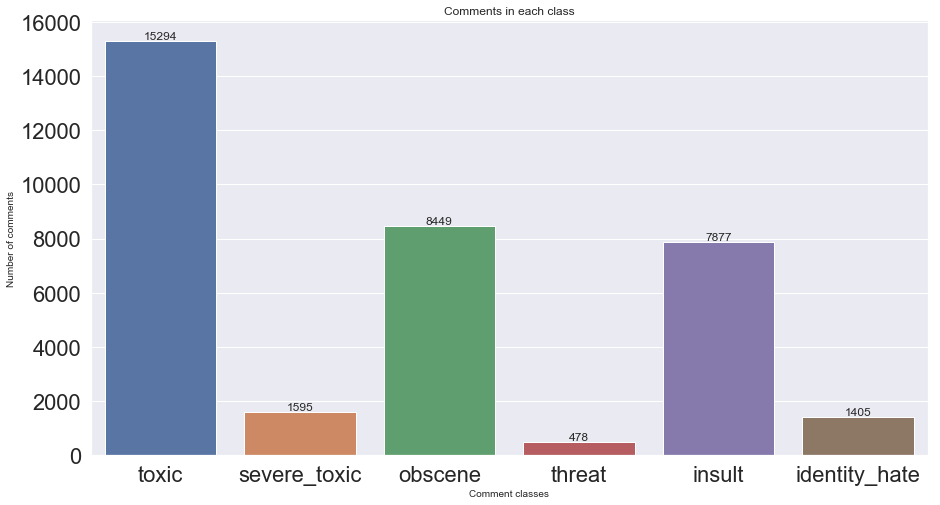

In [6]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(categories, class_counts)
plt.title("Comments in each class", fontsize=12)
plt.ylabel('Number of comments', fontsize=10)
plt.xlabel('Comment classes', fontsize=10)

#adding the text labels
rects = ax.patches
for rect, label in zip(rects, class_counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize=12)

plt.show()

In [7]:
# comments with multi-labels
data_train.iloc[:,2:].sum(axis=1).value_counts()#.iloc[1:]

multi_label_counts = data_train.iloc[:,2:].sum(axis=1).value_counts().iloc[1:]
multi_label_counts

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64

In [8]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import strip_numeric
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np

In [9]:
np.random.seed(2019)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/grace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
stemmer = SnowballStemmer('english')
STOP_WORDS = list(gensim.parsing.preprocessing.STOPWORDS)
# STOP_WORDS.extend([])

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# def clean_html(sentence):
#     tag_re = re.compile('<.*?>')
#     return re.sub(tag_re, ' ', str(sentence))

# def clean_special_char(sentence):
#     cleaned = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]', r'',sentence)
# #     cleaned = re.sub(r'[]',r' ',cleaned)
#     cleaned = cleaned.strip()
#     return cleaned.replace("\n"," ")

def preprocess(text):
    result = []
    text = gensim.utils.simple_preprocess(text, deacc=True)
#     print(text)
    for token in text:
        if token not in STOP_WORDS and len(token)>1:
            result.append(lemmatize_stemming(token))
#     print(result)
    return ' '.join(result)

In [12]:
data_train['clean_comment'] = data_train.comment_text.apply(preprocess)
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit usernam hardcor metallica fan reve...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stick thank t...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man tri edit war guy constant remov relev ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,real suggest improv wonder section statist lat...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page


In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_train, random_state=2019, test_size=0.3, shuffle=True)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train['comment_text'])
vectorizer.fit(test['comment_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [15]:
x_train = vectorizer.transform(train['comment_text'])
y_train = train.drop(labels=['id', 'comment_text'], axis=1)

In [16]:
x_test = vectorizer.transform(test['comment_text'])
y_test = test.drop(labels=['id', 'comment_text'], axis=1)

### one-to-rest: multi-label classification to multiple binary classification problems

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [18]:
LogReg_pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

In [19]:
for category in categories:
    print('**{} comments...**'.format(category))
    
    LogReg_pipeline.fit(x_train, train[category])
    
    #accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

**toxic comments...**
Test accuracy is 0.9366226604278075


**severe_toxic comments...**
Test accuracy is 0.9898270387700535


**obscene comments...**
Test accuracy is 0.9638410762032086


**threat comments...**
Test accuracy is 0.9969710895721925


**insult comments...**
Test accuracy is 0.9602899398395722


**identity_hate comments...**
Test accuracy is 0.9908506016042781




### ensemble => take union of all classes that were predicted = output

- there is a possibility there exist correlations among labels
- binary relevance create new data sets from the original, one for each label and train single-label classifiers
- simple but does not work well when there are dependencies among labels

In [20]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

In [21]:
classifier = BinaryRelevance(GaussianNB())

In [22]:
x_train

<111699x2986139 sparse matrix of type '<class 'numpy.float64'>'
	with 12298195 stored elements in Compressed Sparse Row format>

In [ ]:
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

print("Accuracy = ",accuracy_score(y_test,predictions))

### classifier chains

- take label correlations into consideration

In [ ]:
from skmultilearn.problem_transform import ClassifierChain

In [ ]:
classifier = ClassifierChain(LogisticRegression())
classifier.fit(x_train, y_train)

print("Accuracy = ",accuracy_score(y_test, classifier.predict(x_test)))

In [ ]:
from skmultilearn.problem_transform import LabelPowerset

In [ ]:
classifier = LabelPowerset(LogisticRegression())
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)
print("Accuracy = ",accuracy_score(y_test,predictions))

evaluation :
    should consider subsets of predicted class
    
<img src="./resources/micro_averaging.png" style="width: 400px;">
<img src="./resources/macro_averaging.png" style="width: 400px;">
image from https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

- subset accuracy